In [1]:
import nltk

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
import string
from nltk.tokenize import TreebankWordTokenizer
from nltk import SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn import metrics

from sklearn.model_selection import train_test_split

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

pd.options.display.max_colwidth = 500
pd.options.display.max_rows = 500

!pip install demoji

import demoji
demoji.download_codes()
# set plot style
sns.set()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\stefa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
... OK (Got response in 0.97 seconds)
Writing emoji data to C:\Users\stefa\.demoji\codes.json ...
... OK


# Basic Analysis

In [167]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test_with_no_labels.csv')
df.head()

,sentiment,message,tweetid
0,1,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221
1,1,It's not like we lack evidence of anthropogenic global warming,126103
2,2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


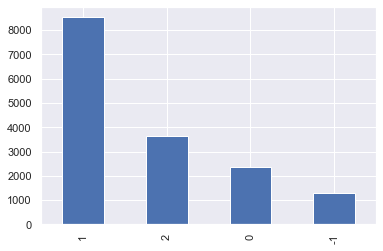

In [20]:
df['sentiment'].value_counts().plot(kind = 'bar')
plt.show()

# Data Cleaning
### 0. Remove Duplicates

The shape of the df before removing duplicates is: (15819, 3)
The shape of the df before removing duplicates is: (14229, 3)


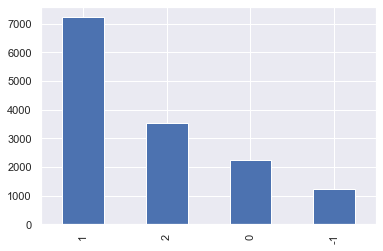

In [168]:
print('The shape of the df before removing duplicates is:', df.shape)

#removing duplicates
df.drop_duplicates(subset='message',inplace=True)
print('The shape of the df before removing duplicates is:', df.shape)

df['sentiment'].value_counts().plot(kind = 'bar')
plt.show()

### 1. Converting html entities

In [169]:
from html.parser import HTMLParser
html_parser = HTMLParser()

df['clean_message'] = df['message'].apply(lambda x: html_parser.unescape(x))
test['clean_message'] = test['message'].apply(lambda x: html_parser.unescape(x))

<ipython-input-169-2d543855c90c>:4: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  df['clean_message'] = df['message'].apply(lambda x: html_parser.unescape(x))
<ipython-input-169-2d543855c90c>:5: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  test['clean_message'] = test['message'].apply(lambda x: html_parser.unescape(x))


### 1.1 Remove RT

In [170]:
z = lambda x: re.compile('\#').sub('', re.compile('RT @').sub('@', x, count=1).strip())
df['clean_message'] = df['clean_message'].apply(z)
test['clean_message'] = test['clean_message'].apply(z)

### 2. Removing twitter handels (@user)

In [171]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

df['clean_message'] = np.vectorize(remove_pattern)(df['clean_message'], "@[\w]*")
test['clean_message'] = np.vectorize(remove_pattern)(test['clean_message'], "@[\w]*")
df.head(10)

,sentiment,message,tweetid,clean_message
0,1,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via"
1,1,It's not like we lack evidence of anthropogenic global warming,126103,It's not like we lack evidence of anthropogenic global warming
2,2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562,: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736,TodayinMaker WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954,": It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. ElectionNight"
5,1,Worth a read whether you do or don't believe in climate change https://t.co/ggLZVNYjun https://t.co/7AFE2mAH8j,425577,Worth a read whether you do or don't believe in climate change https://t.co/ggLZVNYjun https://t.co/7AFE2mAH8j
6,1,RT @thenation: Mike Pence doesn’t believe in global warming or that smoking causes lung cancer. https://t.co/gvWYaauU8R,294933,: Mike Pence doesn’t believe in global warming or that smoking causes lung cancer. https://t.co/gvWYaauU8R
7,1,"RT @makeandmendlife: Six big things we can ALL do today to fight climate change, or how to be a climate activistÃ¢â‚¬Â¦ https://t.co/TYMLu6DbNM hÃ¢â‚¬Â¦",992717,": Six big things we can ALL do today to fight climate change, or how to be a climate activistÃ¢â‚¬Â¦ https://t.co/TYMLu6DbNM hÃ¢â‚¬Â¦"
8,1,"@AceofSpadesHQ My 8yo nephew is inconsolable. He wants to die of old age like me, but will perish in the fiery hellscape of climate change.",664510,"My 8yo nephew is inconsolable. He wants to die of old age like me, but will perish in the fiery hellscape of climate change."
9,1,RT @paigetweedy: no offense… but like… how do you just not believe… in global warming………,260471,: no offense… but like… how do you just not believe… in global warming………


### 3. Lowercase the tweets

In [172]:
df['clean_message'] = df['clean_message'].apply(lambda x: x.lower())
test['clean_message'] = test['clean_message'].apply(lambda x: x.lower())

### 4. Replacing URLs

In [173]:
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
df['clean_message'] = df['clean_message'].replace(to_replace = pattern_url, value = subs_url, regex = True)
test['clean_message'] = test['clean_message'].replace(to_replace = pattern_url, value = subs_url, regex = True)

### 5.Apostrophes

In [174]:
apostrophe_dict = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}
apostrophe_dict

{"ain't": 'am not / are not',
 "aren't": 'are not / am not',
 "can't": 'cannot',
 "can't've": 'cannot have',
 "'cause": 'because',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 "hadn't": 'had not',
 "hadn't've": 'had not have',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he'd": 'he had / he would',
 "he'd've": 'he would have',
 "he'll": 'he shall / he will',
 "he'll've": 'he shall have / he will have',
 "he's": 'he has / he is',
 "how'd": 'how did',
 "how'd'y": 'how do you',
 "how'll": 'how will',
 "how's": 'how has / how is',
 "i'd": 'I had / I would',
 "i'd've": 'I would have',
 "i'll": 'I shall / I will',
 "i'll've": 'I shall have / I will have',
 "i'm": 'I am',
 "i've": 'I have',
 "isn't": 'is not',
 "it'd": 'it had / it would',
 "it'd've": 'it would have',
 "it'll": 'it shall / it will',
 "it'll've": 'it shall have / it will have',
 "it's": 'it has / it is',
 "let's": 'l

In [175]:
def lookup_dict(text, dictionary):
    for word in text.split():
        if word.lower() in dictionary:
            if word.lower() in text.split():
                text = text.replace(word, dictionary[word.lower()])
    return text

df['clean_message'] = df['clean_message'].apply(lambda x: lookup_dict(x,apostrophe_dict))
test['clean_message'] = test['clean_message'].apply(lambda x: lookup_dict(x,apostrophe_dict))

### 6. Short Words and slang/abbreviations

In [176]:
short_word_dict = {
"121": "one to one",
"a/s/l": "age, sex, location",
"adn": "any day now",
"afaik": "as far as I know",
"afk": "away from keyboard",
"aight": "alright",
"alol": "actually laughing out loud",
"b4": "before",
"b4n": "bye for now",
"bak": "back at the keyboard",
"bf": "boyfriend",
"bff": "best friends forever",
"bfn": "bye for now",
"bg": "big grin",
"bta": "but then again",
"btw": "by the way",
"cid": "crying in disgrace",
"cnp": "continued in my next post",
"cp": "chat post",
"cu": "see you",
"cul": "see you later",
"cul8r": "see you later",
"cya": "bye",
"cyo": "see you online",
"dbau": "doing business as usual",
"fud": "fear, uncertainty, and doubt",
"fwiw": "for what it's worth",
"fyi": "for your information",
"g": "grin",
"g2g": "got to go",
"ga": "go ahead",
"gal": "get a life",
"gf": "girlfriend",
"gfn": "gone for now",
"gmbo": "giggling my butt off",
"gmta": "great minds think alike",
"h8": "hate",
"hagn": "have a good night",
"hdop": "help delete online predators",
"hhis": "hanging head in shame",
"iac": "in any case",
"ianal": "I am not a lawyer",
"ic": "I see",
"idk": "I don't know",
"imao": "in my arrogant opinion",
"imnsho": "in my not so humble opinion",
"imo": "in my opinion",
"iow": "in other words",
"ipn": "I’m posting naked",
"irl": "in real life",
"jk": "just kidding",
"l8r": "later",
"ld": "later, dude",
"ldr": "long distance relationship",
"llta": "lots and lots of thunderous applause",
"lmao": "laugh my ass off",
"lmirl": "let's meet in real life",
"lol": "laugh out loud",
"ltr": "longterm relationship",
"lulab": "love you like a brother",
"lulas": "love you like a sister",
"luv": "love",
"m/f": "male or female",
"m8": "mate",
"milf": "mother I would like to fuck",
"oll": "online love",
"omg": "oh my god",
"otoh": "on the other hand",
"pir": "parent in room",
"ppl": "people",
"r": "are",
"rofl": "roll on the floor laughing",
"rpg": "role playing games",
"ru": "are you",
"shid": "slaps head in disgust",
"somy": "sick of me yet",
"sot": "short of time",
"thanx": "thanks",
"thx": "thanks",
"ttyl": "talk to you later",
"u": "you",
"ur": "you are",
"uw": "you’re welcome",
"wb": "welcome back",
"wfm": "works for me",
"wibni": "wouldn't it be nice if",
"wtf": "what the fuck",
"wtg": "way to go",
"wtgp": "want to go private",
"ym": "young man",
"gr8": "great"
}

In [177]:
df['clean_message'] = df['clean_message'].apply(lambda x: lookup_dict(x,short_word_dict))
test['clean_message'] = test['clean_message'].apply(lambda x: lookup_dict(x,short_word_dict))

### 7. Emoticons

In [178]:
emoticon_dict = {
":)": "happy",
":‑)": "happy",
":-]": "happy",
":-3": "happy",
":->": "happy",
"8-)": "happy",
":-}": "happy",
":o)": "happy",
":c)": "happy",
":^)": "happy",
"=]": "happy",
"=)": "happy",
"<3": "happy",
":-(": "sad",
":(": "sad",
":c": "sad",
":<": "sad",
":[": "sad",
">:[": "sad",
":{": "sad",
">:(": "sad",
":-c": "sad",
":-< ": "sad",
":-[": "sad",
":-||": "sad"
}
emoticon_dict

{':)': 'happy',
 ':‑)': 'happy',
 ':-]': 'happy',
 ':-3': 'happy',
 ':->': 'happy',
 '8-)': 'happy',
 ':-}': 'happy',
 ':o)': 'happy',
 ':c)': 'happy',
 ':^)': 'happy',
 '=]': 'happy',
 '=)': 'happy',
 '<3': 'happy',
 ':-(': 'sad',
 ':(': 'sad',
 ':c': 'sad',
 ':<': 'sad',
 ':[': 'sad',
 '>:[': 'sad',
 ':{': 'sad',
 '>:(': 'sad',
 ':-c': 'sad',
 ':-< ': 'sad',
 ':-[': 'sad',
 ':-||': 'sad'}

In [179]:
df['clean_message'] = df['clean_message'].apply(lambda x: lookup_dict(x,emoticon_dict))
test['clean_message'] = test['clean_message'].apply(lambda x: lookup_dict(x,emoticon_dict))

### 8. Emojis

In [22]:
emoji_dict = df['clean_message'].apply(lambda x: demoji.findall(x))


### 9.Replace punctuation with space

In [180]:
df['clean_message'] = df['clean_message'].apply(lambda x: re.sub(r'[^\w\s]',' ',x))
test['clean_message'] = test['clean_message'].apply(lambda x: re.sub(r'[^\w\s]',' ',x))

###  9.Replacing Special Characters with space

In [181]:
df['clean_message'] = df['clean_message'].apply(lambda x: re.sub(r'[^a-zA-Z0-9]',' ',x))
test['clean_message'] = test['clean_message'].apply(lambda x: re.sub(r'[^a-zA-Z0-9]',' ',x))

### 10. Replace ints with space

In [182]:
df['clean_message'] = df['clean_message'].apply(lambda x: re.sub(r'[^a-zA-Z]',' ',x))
test['clean_message'] = test['clean_message'].apply(lambda x: re.sub(r'[^a-zA-Z]',' ',x))

### 11. Remove 1 letter words

In [183]:
df['clean_message'] = df['clean_message'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
test['clean_message'] = test['clean_message'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))

### 12. Tokenisation

In [184]:
tokeniser = TreebankWordTokenizer()
df['tokenised_message'] = df['clean_message'].apply(tokeniser.tokenize)
test['tokenised_message'] = test['clean_message'].apply(tokeniser.tokenize)

### 13. Stemming and lemma

In [185]:
stemmer = SnowballStemmer('english')

def mbti_stemmer(words, stemmer):
    return [stemmer.stem(word) for word in words]

df['stemmed_message'] = df['tokenised_message'].apply(mbti_stemmer, args=(stemmer, ))
test['stemmed_message'] = test['tokenised_message'].apply(mbti_stemmer, args=(stemmer, ))

for i, t in enumerate(df.iloc[15]['tokenised_message']):    
    print ('{:20s} --> {:10s}'.format(t, df.iloc[15]['stemmed_message'][i]))




lemmatizer = WordNetLemmatizer()

def mbti_lemma(words, lemmatizer):
    return [lemmatizer.lemmatize(word) for word in words]  

df['lemma_message'] = df['tokenised_message'].apply(mbti_lemma, args=(lemmatizer, ))  
test['lemma_message'] = test['tokenised_message'].apply(mbti_lemma, args=(lemmatizer, ))  

for i, t in enumerate(df.iloc[1]['tokenised_message']):    
    print ('{:20s} --> {:10s}'.format(t, df.iloc[1]['lemma_message'][i]))

do                   --> do        
not                  --> not       
wan                  --> wan       
na                   --> na        
live                 --> live      
forever              --> forev     
and                  --> and       
nothing              --> noth      
will                 --> will      
because              --> becaus    
climate              --> climat    
change               --> chang     
url                  --> url       
web                  --> web       
it                   --> it        
has                  --> ha        
it                   --> it        
is                   --> is        
not                  --> not       
like                 --> like      
we                   --> we        
lack                 --> lack      
evidence             --> evidence  
of                   --> of        
anthropogenic        --> anthropogenic
global               --> global    
warming              --> warming   


## Solving Class imbalance

In [141]:
df_majority = df[df['sentiment']==1] 
df_minority_0 = df[df['sentiment']==0] 
df_minority_neg1 = df[df['sentiment']==-1] 
df_minority_2 = df[df['sentiment']==2] 

df_minority_0_upsampled = resample(df_minority_0, replace=True, n_samples=8530, random_state=47)      
df_minority_neg1_upsampled = resample(df_minority_neg1, replace=True, n_samples=8530, random_state=47)   
df_minority_2_upsampled = resample(df_minority_2, replace=True, n_samples=8530, random_state=47)   

df_comb = pd.concat([df_majority, df_minority_0_upsampled, df_minority_neg1_upsampled, df_minority_2_upsampled])

## Training and Testing

In [187]:
X = df['clean_message']
y = df['sentiment']

###test
X_real = test['message']

In [ ]:
###stemming
df_comb['stemmed_message'] = df_comb['stemmed_message'].apply(' '.join)
X = df_comb['stemmed_message']
y = df_comb['sentiment']

In [142]:
###lemma
df_comb['lemma_message'] = df_comb['lemma_message'].apply(' '.join)
X = df_comb['lemma_message']
y = df_comb['sentiment']

test['lemma_message'] = test['lemma_message'].apply(' '.join)
X_real = test['lemma_message']

In [154]:
TFID = TfidfVectorizer(stop_words='english', 
                             min_df=1, 
                             max_df=0.9, 
                             ngram_range=(1, 2))

In [155]:
X_vec_t = TFID.fit_transform(X)

###real
X_vec_t_real = TFID.transform(X_real)

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X_vec_t, y, test_size=0.05, random_state=42, stratify=y)

ValueError: Found input variables with inconsistent numbers of samples: [34120, 14229]

## Models

In [192]:
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', 
                             min_df=1, 
                             max_df=0.9, 
                             ngram_range=(1, 2))),
                ('classification', RandomForestClassifier())])


pipe.fit(X_train, y_train)



y_pred_lsvc = pipe.predict(X_test)

print('model: Linear SVC Metrics')
print(metrics.classification_report(y_test, y_pred_lsvc))

model: Linear SVC Metrics
              precision    recall  f1-score   support

          -1       0.83      0.14      0.25       104
           0       0.41      0.44      0.42       227
           1       0.66      0.79      0.72       730
           2       0.76      0.62      0.68       362

    accuracy                           0.64      1423
   macro avg       0.67      0.50      0.52      1423
weighted avg       0.66      0.64      0.63      1423



In [160]:
### Linear SVC
lsvc = LinearSVC()
# Fit model to training data
lsvc.fit(X_train, y_train)
# Use trained model to run prediction on validation data
lsvc_pred= lsvc.predict(X_test)

In [161]:
print("Linear SVC Metrics")
print(metrics.classification_report(y_test, lsvc_pred))

Linear SVC Metrics
              precision    recall  f1-score   support

          -1       0.98      1.00      0.99       427
           0       0.95      0.97      0.96       426
           1       0.95      0.85      0.90       427
           2       0.92      0.98      0.95       426

    accuracy                           0.95      1706
   macro avg       0.95      0.95      0.95      1706
weighted avg       0.95      0.95      0.95      1706



In [162]:
lsvc_pred_real= lsvc.predict(X_vec_t_real)

In [163]:
test['sentiment'] = lsvc_pred_real

In [164]:
test[['tweetid','sentiment']].to_csv('SVC_cleaned_hypers.csv', index=False)